In [1]:
import numpy as np
import json
from livecellx.core import (
    SingleCellTrajectory,
    SingleCellStatic,
    SingleCellTrajectoryCollection,
)
from livecellx.segment.detectron_utils import (
    convert_detectron_instance_pred_masks_to_binary_masks,
    convert_detectron_instances_to_label_masks,
    segment_images_by_detectron,
    segment_single_img_by_detectron_wrapper,
)
from livecellx.core.datasets import LiveCellImageDataset
from livecellx.preprocess.utils import (
    overlay,
    enhance_contrast,
    normalize_img_to_uint8,
)
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from pathlib import Path
import pandas as pd

## Convert Labelme Json to COCO Json

run the following code once for generating coco json
```
import livecellx.segment
import livecellx.annotation
import livecellx.annotation.labelme2coco
import os
labelme_json_folder = r"""../datasets/a549_ccnn/annotation_data"""
dataset_folder_path = r"""../datasets/a549_ccnn/original_data"""
export_dir = "./notebook_results/correction_cnn_v0.0.0/"
os.makedirs(export_dir, exist_ok=True)
livecellx.annotation.labelme2coco.convert(
    labelme_json_folder,
    export_dir,
    train_split_rate=0.9,
    dataset_folder_path=dataset_folder_path,
    # is_image_in_json_folder=True,
    image_file_ext="tif",
    # image_file_ext="png",
)
```

## Load COCO into SingleCell Objects

In [2]:
from pycocotools.coco import COCO

# coco_data = COCO("../datasets/a549_ccnn/a549_ccnn_coco_v0.0.0/train.json")
# out_dir = Path("./notebook_results/a549_ccp_vim/train_data_v8/")
coco_data = COCO("../datasets/a549_ccnn/a549_ccnn_coco_v0.0.0/val.json")
out_dir = Path("./notebook_results/a549_ccp_vim/test_data_v8/")

coco_data.anns.keys(), coco_data.anns[1].keys(), coco_data.anns[1]["segmentation"][0][
    :5
]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


(dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 dict_keys(['iscrowd', 'image_id', 'bbox', 'segmentation', 'category_id', 'id', 'area']),
 [1066, 1135, 1055, 1136, 1045])

In [3]:
coco_data.imgs.keys(), coco_data.imgs[1].keys(), coco_data.imgs[1]["file_name"],


(dict_keys([1, 2, 3, 4, 5, 6, 7]),
 dict_keys(['height', 'width', 'id', 'file_name']),
 '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY4_DIC_tile1_DIC-FITC.tif')

In [4]:
from typing import List

from livecellx.annotation.coco_utils import coco_to_sc

single_cells = coco_to_sc(coco_data)



In [5]:
len(single_cells)

27

save a list of single cell objects

In [6]:
SingleCellStatic.write_single_cells_json(
    single_cells, "../datasets/a549_ccnn/single_cells.json"
)


In [7]:
import glob

sample_sc = single_cells[0]
raw_img_dataset = sample_sc.img_dataset
seg_data_dir = "../datasets/a549_ccnn/seg_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11"
seg_paths = glob.glob(os.path.join(seg_data_dir, "*.png"))
print("sample seg paths:", seg_paths[:2])
matched_time2seg = {}
# for time, img_path in raw_img_dataset.time2url.items():
#     substr = os.path.basename(img_path).split(".")[0]
#     print("substr:", substr)
#     for seg_path
#     break
corrected_indices = []
for seg_path in seg_paths:
    substr = os.path.basename(seg_path).split(".")[0] # get rid of extension
    substr = substr[4:]  # get rid of seg_ prefix
    img, path, index = raw_img_dataset.get_img_by_url(
        substr, return_path_and_time=True, ignore_missing=True
    )
    if path is None:
        print("skip due to substr not found:", substr)
        continue
    matched_time2seg[index] = seg_path

crappy_seg_data = LiveCellImageDataset(time2url=matched_time2seg, ext="png")
sample_sc.mask_dataset = crappy_seg_data
assert len(crappy_seg_data) == len(raw_img_dataset)


sample seg paths: ['../datasets/a549_ccnn/seg_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/seg_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T01_XY2_DIC_tile8_DIC-FITC.png', '../datasets/a549_ccnn/seg_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/seg_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY4_DIC_tile0_DIC-FITC.png']
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T01_XY2_DIC_tile8_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY4_DIC_tile0_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T01_XY2_DIC_tile3_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T01_XY1_DIC_tile8_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T07_XY2_DIC_tile8_DIC-FITC
skip due to substr not fo

## Generate Synthetic Undersegmentation data

<AxesSubplot: >

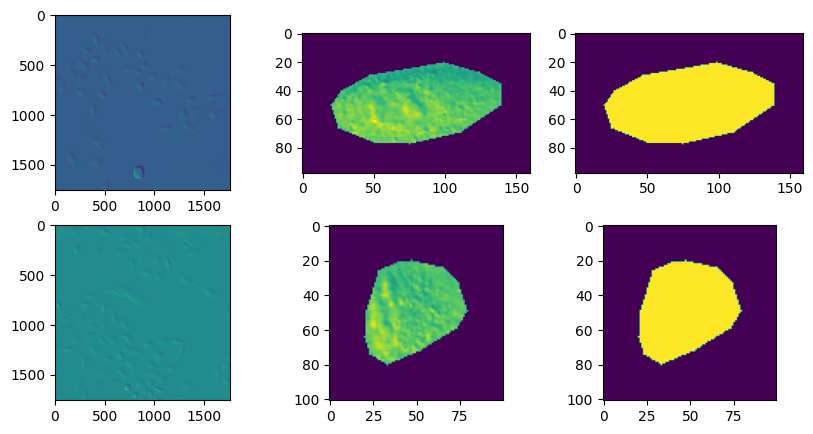

In [8]:
sc1 = single_cells[10]
sc2 = single_cells[1]

padding=20
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
sc1.show(padding=padding, ax=axes[0][0])
sc1.show_contour_img(padding=padding, ax=axes[0][1])
sc1.show_contour_mask(padding=padding, ax=axes[0][2])
sc2.show(padding=padding, ax=axes[1][0])
sc2.show_contour_img(padding=padding, ax=axes[1][1])
sc2.show_contour_mask(padding=padding, ax=axes[1][2])

In [9]:
from livecellx.segment.ou_simulator import combine_two_scs_monte_carlo, compute_distance_by_contour,viz_check_combined_sc_result, gen_gauss_sc_bg, gen_sc_bg_crop, gen_synthetic_nonoverlap_by_two_scs, gen_synthetic_overlap_scs, gen_underseg_scs_sample, gen_aug_diff_mask, gen_underseg_scs, _gen_underseg_scs_sample_wrapper, compute_two_contours_min_distance, merge_two_scs_nonoverlap, merge_two_scs_overlap, move_util_in_range, find_contours_opencv

**Important** make sure there are enough contour points, because we will use contour points to calculate min distances later, otherwise two cells may be too close due to lack of contour points. 

In [10]:
for sc in single_cells:
    found_contours = find_contours_opencv(sc.get_contour_mask(crop=False))
    assert len(found_contours) == 1, "found more than 1 contour"
    sc.update_contour(found_contours[0])

combine two scs using monte carlo

In [11]:
# bg_scale = 3.0

# for i in range(4):
#     new_sc1, new_sc2 = combine_two_scs_monte_carlo(sc1, sc2, bg_img=None)
#     viz_check_combined_sc_result(new_sc1, new_sc2)

# for i in range(4):
#     new_sc1, new_sc2 = combine_two_scs_monte_carlo(sc1, sc2, bg_img=None, fix_sc1=True)
#     viz_check_combined_sc_result(new_sc1, new_sc2)

In [12]:
# viz_check_combined_sc_result(new_sc1, new_sc2)

check overseg synthesis

In [13]:
# # check results
# for i in tqdm(range(4)):
#     new_sc1, new_sc2, _, is_success = gen_synthetic_overlap_scs(sc1, sc2)
#     viz_check_combined_sc_result(new_sc1, new_sc2)

### Generate synthetic non-overlapping underseg cells 

example: compute distance of two single cells

In [14]:

sc3 = single_cells[3]
# fig, axes = plt.subplots(1, 3, figsize=(10, 5))
# sc1.show_contour_img(ax=axes[0], padding=10000)
# sc2.show_contour_img(ax=axes[1], padding=10000)
# sc3.show_contour_img(ax=axes[2], padding=10000)


compute_distance_by_contour(sc1, sc2), compute_distance_by_contour(sc1, sc3), compute_distance_by_contour(sc2, sc3)

(497.09657009478553, 862.2319873444733, 340.6024075076393)

example: generate a gaussian background

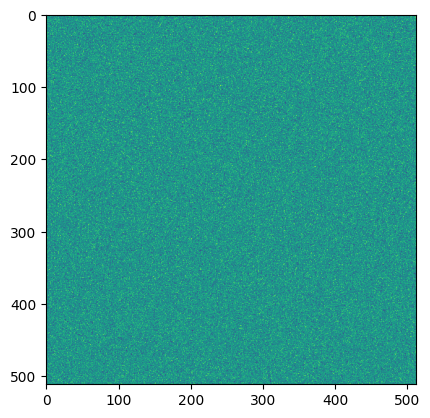

In [15]:
plt.imshow(gen_gauss_sc_bg(sc1, (512, 512)))

example: generate a backgroudn according to bg

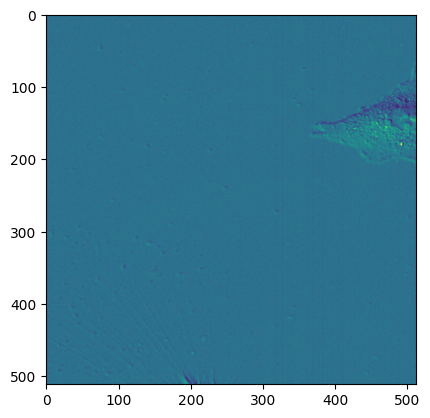

In [16]:

plt.imshow(gen_sc_bg_crop(sc1, (512, 512)))

In [17]:


# # check results
# min_dist = 30
# max_dist = 100
# for i in tqdm(range(2)):
#     new_sc1, new_sc2, _, is_success = gen_synthetic_nonoverlap_by_two_scs(sc1, sc2, gen_bg_func=gen_sc_bg_crop, min_dist=min_dist, max_dist=max_dist, dist_per_move=30)
#     viz_check_combined_sc_result(new_sc1, new_sc2)

# for i in tqdm(range(2)):
#     new_sc1, new_sc2, _, is_success = gen_synthetic_nonoverlap_by_two_scs(sc1, sc2, gen_bg_func=gen_gauss_sc_bg, min_dist=min_dist, max_dist=max_dist, dist_per_move=30)
#     viz_check_combined_sc_result(new_sc1, new_sc2)

example: generate nonoverlap scs and move them together

In [18]:
import random
# for i in tqdm(range(20)):
#     # randomly choose sc1 and sc2
#     sc1, sc2 = random.sample(single_cells, 2)
#     new_sc1, new_sc2, _, is_success = gen_synthetic_nonoverlap_by_two_scs(sc1, sc2, gen_bg_func=gen_gauss_sc_bg, min_dist=10, max_dist=1000,  min_reserved_area_percent=1)
#     viz_check_combined_sc_result(new_sc1, new_sc2)
#     # move_two_syn_scs_close_or_apart(new_sc1, new_sc2, dist=40, bg_img=gen_gauss_sc_bg(new_sc1, shape=new_sc1.get_img().shape), inplace=True)
#     move_util_in_range(new_sc1, new_sc2, dist_per_move=30, bg_img=gen_gauss_sc_bg(new_sc1, shape=new_sc1.get_img().shape), min_dist=10, max_dist=40, inplace=True, max_move=100)
#     viz_check_combined_sc_result(new_sc1, new_sc2)

In [19]:
from typing import Tuple
from skimage.measure import regionprops
import pandas as pd
from livecellx.core.io_utils import save_tiff
from livecellx.segment.ou_utils import csn_augment_helper, underseg_overlay_gt_masks, gen_aug_diff_mask


check sc areas 
```
for sc in single_cells:
    prop = sc.compute_regionprops()
    assert prop.area > 5
```

In [20]:
import itertools
from skimage.measure import find_contours
import cv2

Viz merge two cells

Overlap case

In [21]:
# new_sc1, new_sc2, _, _ = gen_synthetic_overlap_scs(sc1, sc2, min_reserved_area_percent=1)
# sc3, is_success = merge_two_scs_overlap(new_sc1, new_sc2)
# if is_success:
#     sc3.show()

Nonoverlap case

In [22]:
# for i in range(1):
#     sc1, sc2 = random.sample(single_cells, 2)
#     new_sc1, new_sc2, _, _ = gen_synthetic_nonoverlap_by_two_scs(sc1, sc2, gen_bg_func=gen_gauss_sc_bg, min_dist=10, max_dist=50, bg_scale=2, min_reserved_area_percent=1)
#     sc3, is_success = merge_two_scs_nonoverlap(new_sc1, new_sc2)
#     if is_success:
#         sc3.show()
#         plt.show()

show nonoverlap merge case: merge by dilation. sc3 represents a generated under-segmentation case.

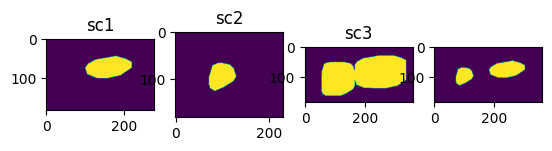

In [23]:
res_dict = gen_synthetic_nonoverlap_by_two_scs(sc1, sc2, gen_bg_func=gen_sc_bg_crop)
new_sc1, new_sc2, _, _ = res_dict["new_sc1"], res_dict["new_sc2"], res_dict["bg_img"], res_dict["is_success"]
sc3, is_success = merge_two_scs_nonoverlap(new_sc1, new_sc2)
if is_success:
    fig, axes = plt.subplots(1, 4)
    padding = 100
    new_sc1.show_mask(ax=axes[0], crop=True, padding=padding)
    axes[0].set_title("sc1")
    new_sc2.show_mask(ax=axes[1], crop=True, padding=padding)
    axes[1].set_title("sc2")
    sc3.show_mask(ax=axes[2], crop=True, padding=padding)
    axes[2].set_title("sc3")

    axes[3].imshow(new_sc1.get_mask() + new_sc2.get_mask())


In [24]:
def test_gen_underseg_scs():
    subdir = Path("synthetic_underseg_overlap")
    underseg_out_dir = out_dir / subdir
    gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=0, num_cells=4, total_sample_num=1)
    gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=1, num_cells=4, total_sample_num=1)

def gen_syn_overlap_underseg_data_v8(sample_num=10):
    subdir = Path("synthetic_underseg_overlap")
    underseg_out_dir = out_dir / subdir
    # generate training data
    gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=0, num_cells=4, total_sample_num=sample_num)
    gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=sample_num, num_cells=3, total_sample_num=sample_num)
    gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=sample_num * 2, num_cells=2, total_sample_num=sample_num * 2)


def gen_syn_overlap_underseg_test_data_v8(sample_num = 100):
    test_out_dir = Path("./notebook_results/a549_ccp_vim/test_data_v8/")
    def _save_all_df(all_df):
        all_df.to_csv(test_out_dir / "synthetic_underseg_overlap" / "data.csv", index=False)

    subdir = Path("synthetic_underseg_overlap")
    test_underseg_out_dir = test_out_dir / subdir
    # generate training data
    all_df = gen_underseg_scs(scs=single_cells, save_dir=test_underseg_out_dir, sample_id_offset=0, num_cells=4, total_sample_num=sample_num)
    _save_all_df(all_df)
    df = gen_underseg_scs(scs=single_cells, save_dir=test_underseg_out_dir, sample_id_offset=sample_num, num_cells=3, total_sample_num=sample_num)
    all_df = pd.concat([all_df, df], ignore_index=True)
    _save_all_df(all_df)
    df = gen_underseg_scs(scs=single_cells, save_dir=test_underseg_out_dir, sample_id_offset=sample_num * 2, num_cells=2, total_sample_num=sample_num * 2)
    all_df = pd.concat([all_df, df], ignore_index=True)
    _save_all_df(all_df)



def gen_syn_nonoverlap_underseg_train_data(gen_bg_func, subdir, sample_num = 10, out_dir=out_dir):
    underseg_out_dir = out_dir / subdir
    def _save_all_df(all_df):
        all_df.to_csv(underseg_out_dir / "data.csv", index=False)

    # generate training data    
    generator_args = {
        "min_dist": 1,
        "max_dist": 10,
        "bg_scale": 3,
        "gen_bg_func": gen_bg_func,
        "min_reserved_area_percent": 0.9
    }
    all_df = gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=0, num_cells=4, total_sample_num=sample_num, sc_generator_func=gen_synthetic_nonoverlap_by_two_scs, sc_generator_func_kwargs=generator_args, merge_func=merge_two_scs_nonoverlap)
    _save_all_df(all_df)
    df = gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=sample_num, num_cells=3, total_sample_num=sample_num, sc_generator_func=gen_synthetic_nonoverlap_by_two_scs, sc_generator_func_kwargs=generator_args, merge_func=merge_two_scs_nonoverlap)
    all_df = pd.concat([all_df, df], ignore_index=True)
    _save_all_df(all_df)
    df = gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=sample_num * 2, num_cells=2, total_sample_num=sample_num * 2, sc_generator_func=gen_synthetic_nonoverlap_by_two_scs, sc_generator_func_kwargs=generator_args, merge_func=merge_two_scs_nonoverlap)
    all_df = pd.concat([all_df, df], ignore_index=True)
    _save_all_df(all_df)


Single core version for testing

check if each single cell has mask ground truth information

In [25]:
for sc in single_cells:
    assert (sc.mask_dataset is not None) or (sc.contour is not None)

Test `gen_underseg_scs_sample`: visually check if `cur_merged_s`c and `merged_scs` are correct.

In [26]:
# for i in range(10):
#     tmp_scs = random.sample(single_cells, 3)
#     res_dict = gen_underseg_scs_sample(scs=tmp_scs, num_cells=3, viz_check=True, sc_generator_func=gen_synthetic_nonoverlap_by_two_scs, sc_generator_func_kwargs={"min_dist": 1, "max_dist": 10, "bg_scale": 3, "gen_bg_func": gen_gauss_sc_bg}, merge_func=merge_two_scs_nonoverlap)
#     if not res_dict["is_success"]:
#         continue
#     merged_scs = res_dict["merged_scs"]
#     cur_merged_sc = res_dict["cur_merged_sc"]
#     cur_merged_sc.show_panel()

#     for sc in merged_scs:
#         print(sc.bbox)
#         sc.show_panel(padding=0)
#         plt.show()

Center the cur_merged_cells and each synthesized cells

In [27]:
for i in range(1):
    tmp_scs = random.sample(single_cells, 3)
    gen_underseg_scs_sample(scs=tmp_scs, num_cells=3, viz_check=True, sc_generator_func=gen_synthetic_nonoverlap_by_two_scs, sc_generator_func_kwargs={"min_dist": 1, "max_dist": 10, "bg_scale": 3, "gen_bg_func": gen_gauss_sc_bg, "min_reserved_area_percent": 0.9}, merge_func=merge_two_scs_nonoverlap)
    plt.show()

In [ ]:
def test_gen():
    subdir = Path("synthetic_underseg_nonoverlap_test")
    underseg_out_dir = out_dir / subdir
    generator_args =    generator_args = {
        "min_dist": 1,
        "max_dist": 10,
        "bg_scale": 3,
        "gen_bg_func": gen_gauss_sc_bg,
        "min_reserved_area_percent": 0.9
    }
    df = gen_underseg_scs(
        scs=single_cells,
        save_dir=underseg_out_dir,
        sample_id_offset=0,
        num_cells=3,
        total_sample_num=50,
        sc_generator_func=gen_synthetic_nonoverlap_by_two_scs,
        sc_generator_func_kwargs=generator_args,
        merge_func=merge_two_scs_nonoverlap,
        viz_check=True,
        parallel=False,
    )


In [ ]:
# test_gen()

In [ ]:
!rm -r $out_dir

In [ ]:
# train data
# gen_syn_nonoverlap_underseg_train_data(gen_bg_func=gen_gauss_sc_bg, subdir=Path("synthetic_underseg_nonoverlap_gauss"), sample_num=500);

# test data
gen_syn_nonoverlap_underseg_train_data(gen_bg_func=gen_gauss_sc_bg, subdir=Path("synthetic_underseg_nonoverlap_gauss"), sample_num=50, out_dir=Path("./notebook_results/a549_ccp_vim/test_data_v8/")

In [ ]:
# gen_syn_underseg_data_v8(sample_num=1000)
# gen_syn_overlap_underseg_test_data_v8()

In [ ]:
# gen_underseg_scs(scs=single_cells, total_sample_num=5, save_dir=None, num_cells=3, viz_check=True)

In [ ]:
# gen_underseg_scs(scs=single_cells, total_sample_num=5, save_dir=None, num_cells=2, viz_check=True)

In [ ]:
dataframes = []
for subdir in out_dir.iterdir():
    if subdir.is_dir():
        data_path = subdir / "data.csv"
        dataframe = pd.read_csv(data_path)
        dataframe["subdir"] = subdir.name
        dataframes.append(dataframe)
combined_dataframe = pd.concat(dataframes)
combined_dataframe.to_csv(out_dir / "train_data.csv", index=False)

Now we need to handle two cases:
1) there is any overlap between two objects  
    a) simply dilate and create underseg cases  
2) there is no overlap (future work) 
    b) fill in the pixels in-between the two objects  
    c) 

## Combine data.csv files generated in each subfolder

In [ ]:
dataframes = []
for subdir in out_dir.iterdir():
    if subdir.is_dir():
        data_path = subdir / "data.csv"
        dataframe = pd.read_csv(data_path)
        dataframe["subdir"] = subdir.name
        dataframes.append(dataframe)
combined_dataframe = pd.concat(dataframes)
combined_dataframe.to_csv(out_dir / "train_data.csv", index=False)

In [ ]:
len(combined_dataframe)